# Лабораторная работа №5

**Тема: "Автокорреляция"**

Работу выполнил

студент группы 5130901/20201

Нестеренко Сергей Андреевич

---

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
from thinkdsp import normalize, unbias, read_wave, PinkNoise, decorate, UncorrelatedGaussianNoise, Spectrum, Wave, Noise
import numpy as np
import matplotlib.pyplot as plt

## Упражнение 5.1

В файле `chap05.ipynb` представлена функция, при помощи которой можно рассчитать автокорреляции для различных `lag`. Возьмем некоторый вокальный чирп и при помощи данной функции оценим высоты тона для нескольких времен начала сегмента.

In [3]:
def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr
def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

Возьмем вокальный чирп из примера.

In [4]:
vocal_glissando = read_wave('./audio/vocal-glissando.wav')
vocal_glissando.make_audio()

Построим спектрограмму. На ней видно, как со временем снижается тон.

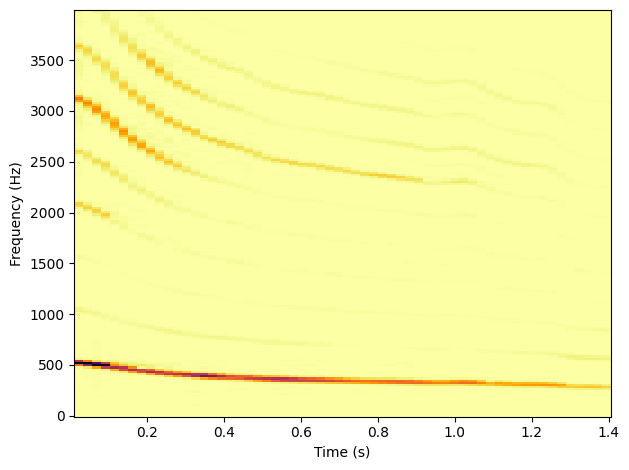

In [16]:
vocal_glissando.make_spectrogram(2048).plot(high=4000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Возьмем сегмент, начиная с 0:00. Получим автокорреляцию.

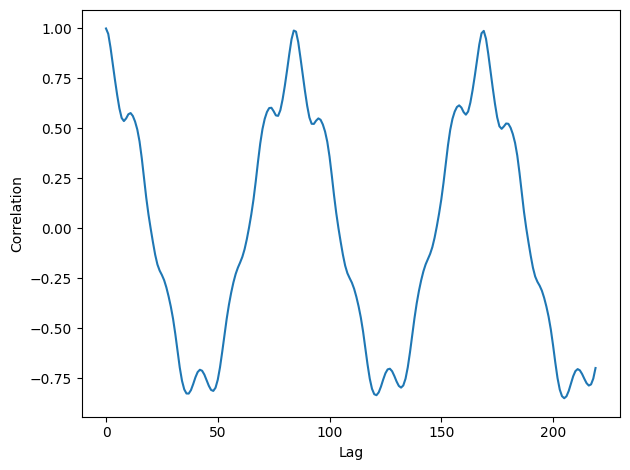

In [6]:
segment1 = vocal_glissando.segment(start=0.0, duration=0.01)
lags1, corrs1 = autocorr(segment1)
plt.plot(lags1, corrs1)
decorate(xlabel='Lag', ylabel='Correlation')

Найдем lag, при котором встречается первый пик корреляции. Исходя из этого, получим частоту для этого сегмента.

In [10]:
lag1 = lags1[corrs1.index(max(corrs1[50:100]))]
period1 = lag1 / segment1.framerate
frequency1 = 1 / period1
print(f'lag: {lag1}\nfrequency: {frequency1:.2f} Hz')

lag: 84
frequency:525.00 Hz


Аналогично найдем частоту на небольшом сегменте, начиная с 0.5 с.

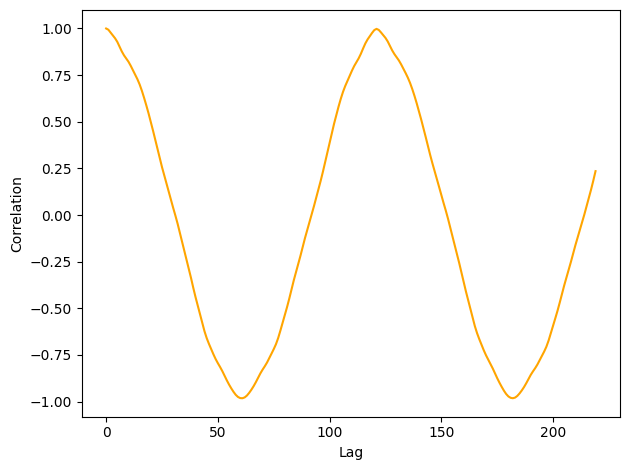

In [8]:
segment2 = vocal_glissando.segment(start=0.5, duration=0.01)
lags2, corrs2 = autocorr(segment2)
plt.plot(lags2, corrs2, color='orange')
decorate(xlabel='Lag', ylabel='Correlation')

In [12]:
lag2 = lags2[corrs2.index(max(corrs2[100:150]))]
period2 = lag2 / segment2.framerate
frequency2 = 1 / period2
print(f'lag: {lag2}\nfrequency: {frequency2:.2f} Hz')

lag: 121
frequency: 364.46 Hz


## Упражнение 5.2

Инкапсулируем под для оценки основной частоты периодического сигнала, использованный выше в 2 примерах, в отдельную функцию. Назовем её `estimate_fundamental`.

In [42]:
def estimate_fundamental(segment: Wave, start: int, end: int) -> np.float64:
    lags, corrs = autocorr(segment)
    lag = lags[corrs.index(max(corrs[start:end]))]
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Для тестирования функции воспользуемся фрагментом с глиссандо из композиции "Rhapsody in Blue". Этот фрагмент был ранее использован в 3 лабораторной работе.

In [31]:
wave = read_wave('./audio/rhapblue.wav')
wave.make_audio()

Построим спектрограмму записи, чтобы визуально оценить высоту основного тона в различные моменты времени.

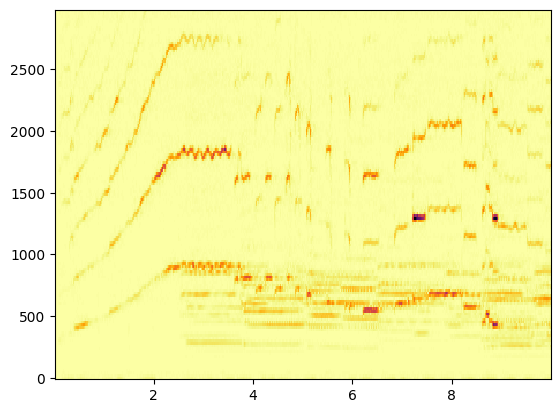

In [52]:
wave.make_spectrogram(512).plot(high=3000)

Рассмотрим пример 1. Возьмем небольшой сегмент, начиная с 1-й секунды.

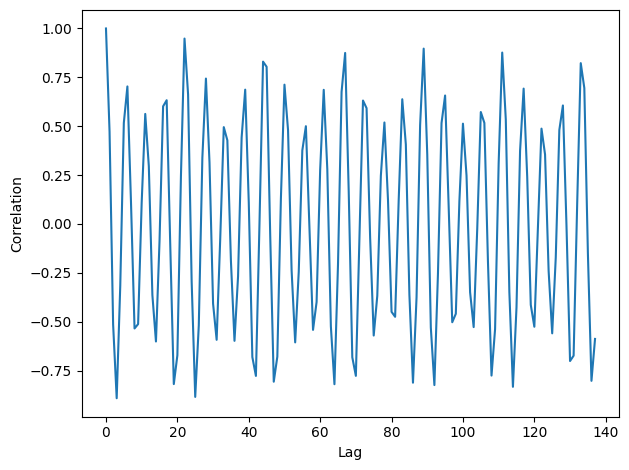

In [37]:
segment1 = wave.segment(start=1, duration=0.025)
lags1, corrs1 = autocorr(segment1)
plt.plot(lags1, corrs1)
decorate(xlabel='Lag', ylabel='Correlation')

Из графика видно, что максимум искать нужно между 20 и 30. Укажем границы поиска как start и end. Получим 501 Гц, что соответствует самой низкой из выделяющихся на спектрограмме гармоник.

In [50]:
estimate_fundamental(segment1, 20, 30)

np.float64(501.1363636363636)

Пример 2. Возьмем небольшой сегмент, начиная со 2-й секунды.

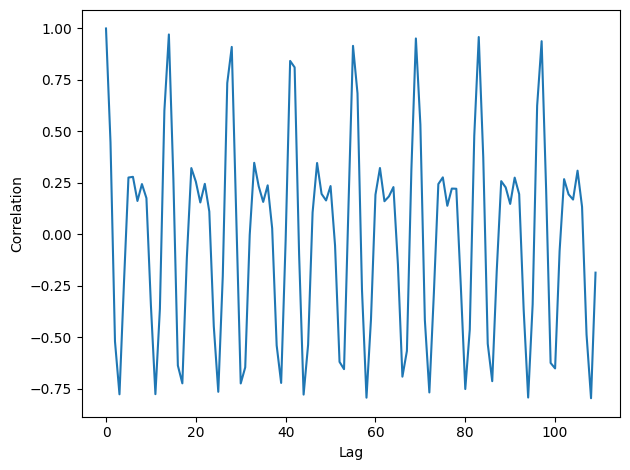

In [48]:
segment2 = wave.segment(start=2, duration=0.02)
lags2, corrs2 = autocorr(segment2)
plt.plot(lags2, corrs2)
decorate(xlabel='Lag', ylabel='Correlation')

Получим 787.5 Гц. Это снова очень похоже на первую гармонику (то есть основной тон) на заданном интервале времени.

In [49]:
estimate_fundamental(segment2, 7, 15)

np.float64(787.5)

Наложив полученные результаты на спектрограмму, обнаружим, что они, действительно, выглядят правдоподобно.

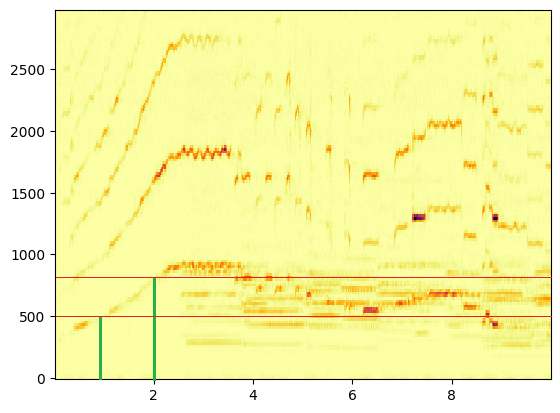

## Упражнение 5.3

Воспользуемся данными о стоимости криптовалюты Bitcoin, как и в предыдущей работе. Построим график автокорреляционной функции.

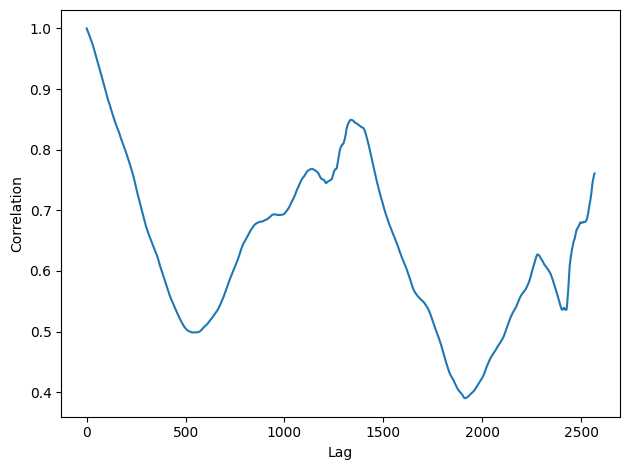

In [56]:
import pandas as pd

df = pd.read_csv('./csv/Bitcoin-price-USD.csv')
btc = Wave(
    ys=df['Price'],
    ts=df.index,
    framerate=1,
)
blags, bcorrs = autocorr(btc)
plt.plot(blags, bcorrs)
decorate(xlabel='Lag', ylabel='Correlation')

Из полученного графика видно, что у графика цен биткоина есть некоторые признаки периодичности, так как график автокорреляционной функции напоминает периодический график. Однако говорить о строгой периодичности нельзя.

## Упражнение 5.4

В блокноте `saxophone.ipynb` рассмотрен пример с *подавленной основной*. Это явление заключается в том, что в сигнале, где основная гармоника имеет нулевую амплитуду, она всё равно отчетливо слышится за счет наличия других гармоник.

Возьмем другой сегмент записи и рассмотрим этот эффект на нём.

In [72]:
if not os.path.exists('./audio/code_100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav

In [77]:
saxophone = read_wave('./audio/code_100475__iluppai__saxophone-weep.wav')
saxophone.normalize()
saxophone.make_audio()

Возьмем сегмент, где играется самая высокая в данном фрагменте нота.

In [87]:
seg = saxophone.segment(start=6.0, duration=0.5)
seg.make_audio()

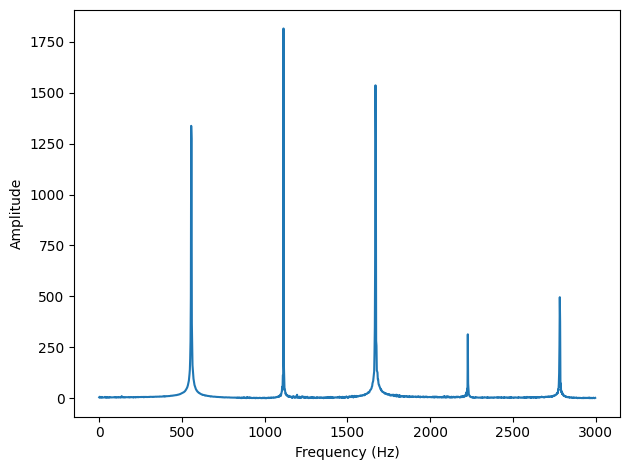

In [80]:
spectrum = seg.make_spectrum()
spectrum.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

На спектре видно, что первая гармоника имеет частоту между 500 и 600 Гц. Занулим её и вновь посмотрим на спектр.

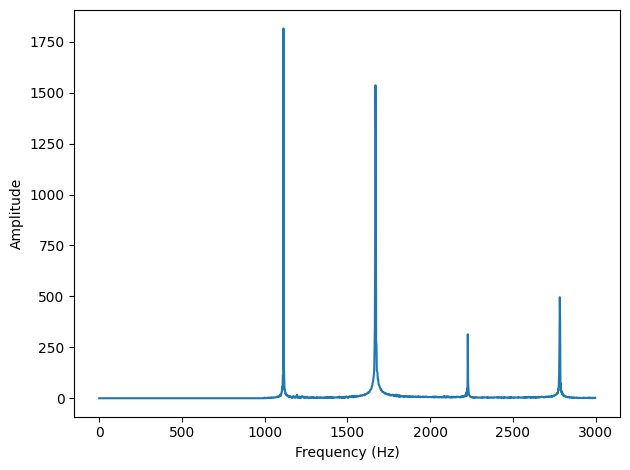

In [84]:
spectrum2 = seg.make_spectrum()
spectrum2.high_pass(1000)
spectrum2.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Прослушаем полученную запись. Она звучит так, будто играется та же самая нота. Тем не менее, слышимой частоты в спектре нет.

In [86]:
segment2 = spectrum2.make_wave()
segment2.make_audio()